In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import Xception ,  VGG19,EfficientNetB7, DenseNet201
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
data_dir = r"D:\CAPSTONE 400A\cse438\lung_colon_image_set\lung_image_sets"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
labels = df['labels']
print(df)


                                               filepaths    labels
0      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
1      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
2      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
3      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
4      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
...                                                  ...       ...
14995  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14996  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14997  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14998  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14999  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc

[15000 rows x 2 columns]


In [4]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [5]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.


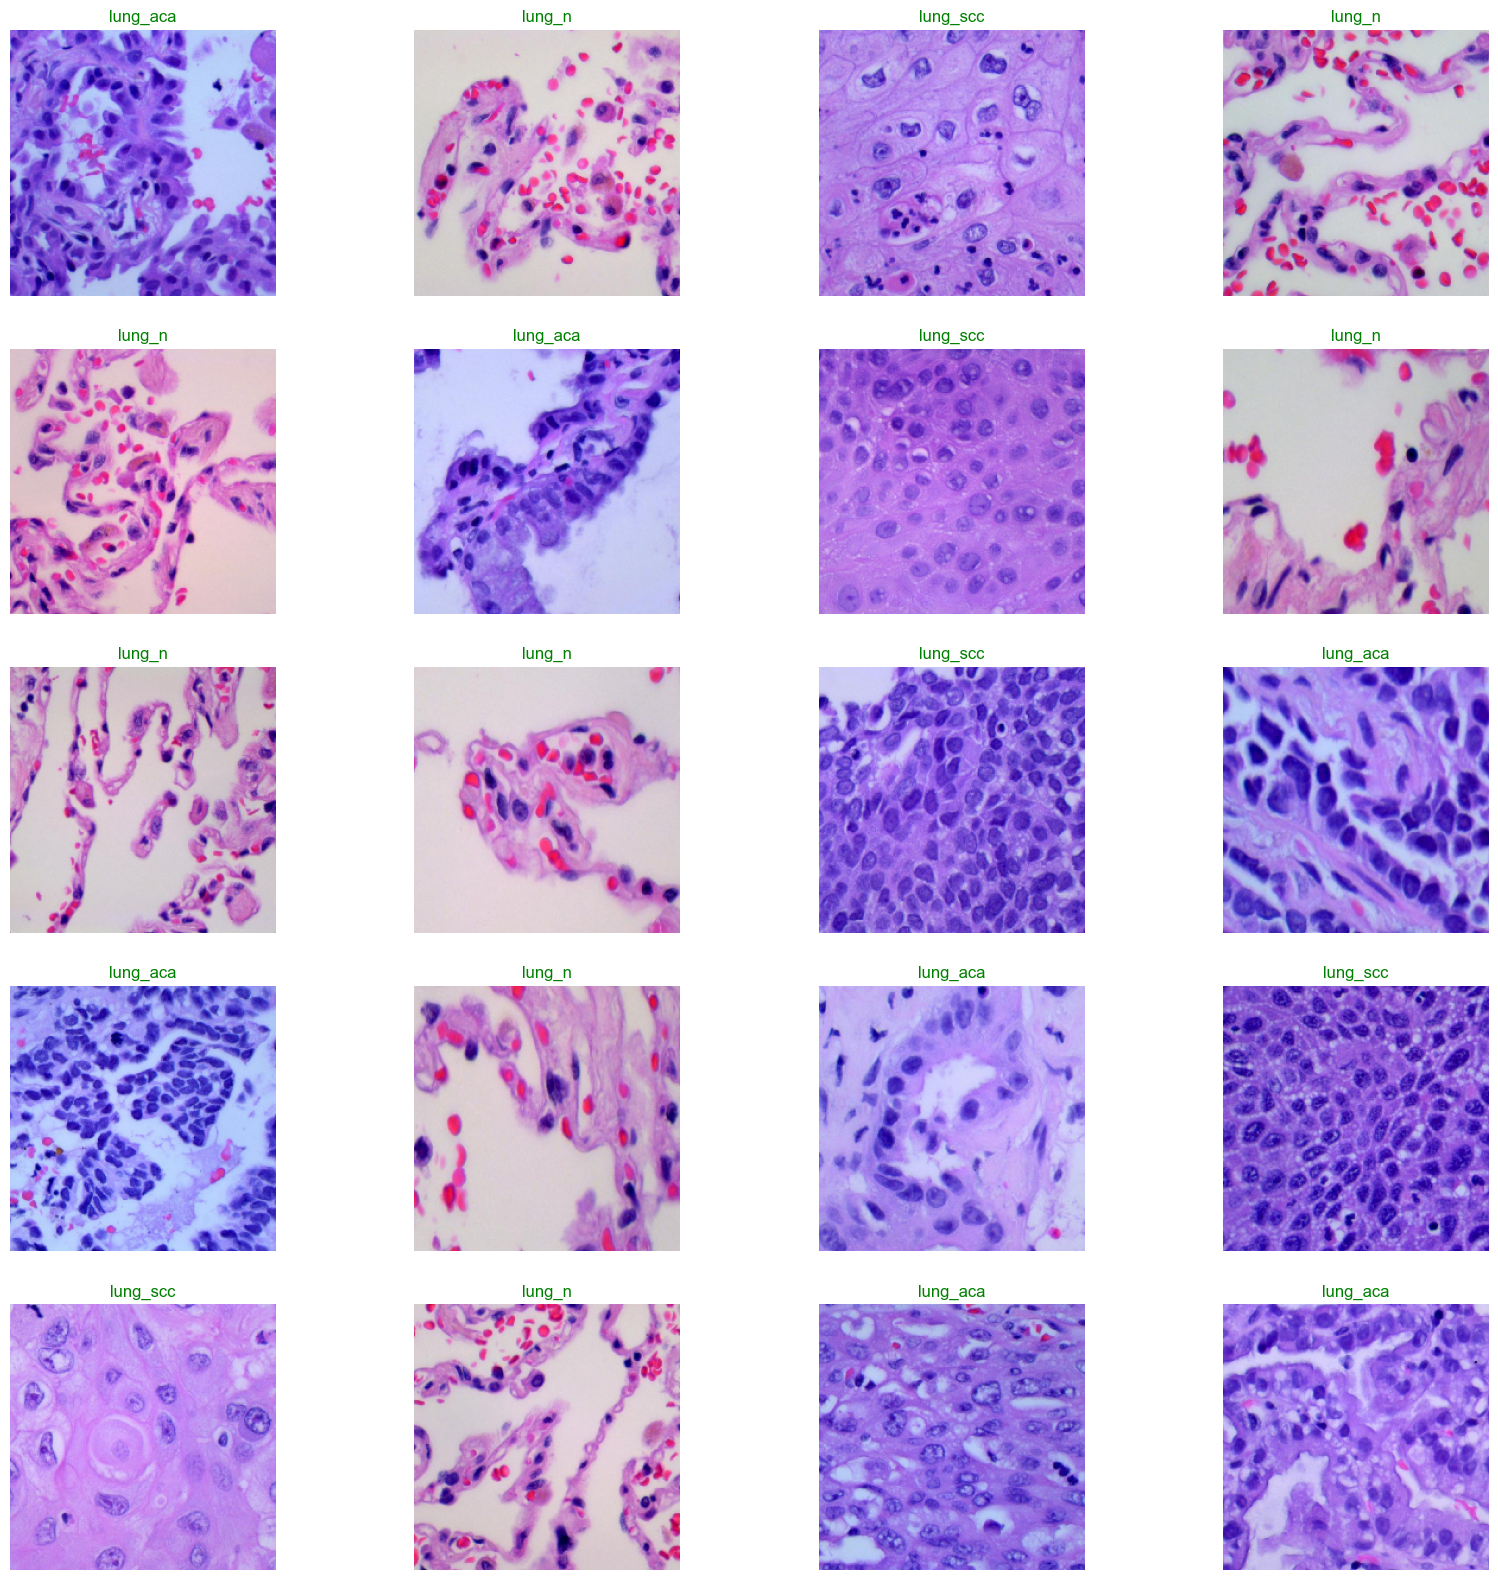

In [6]:
import numpy as np
import matplotlib.pyplot as plt
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes[index] 
    plt.title(class_name, color= 'green', fontsize= 12)
    plt.axis('off')
plt.show()



In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Reshape, Multiply, SpatialDropout2D, Input, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers


class CustomBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dropout_rate, **kwargs):
        super(CustomBlock, self).__init__(**kwargs)
        self.conv = Conv2D(filters, kernel_size, padding='same')
        self.batch_norm = BatchNormalization()
        self.spatial_dropout = SpatialDropout2D(dropout_rate)
        self.activation = Activation('relu')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.batch_norm(x)
        x = self.spatial_dropout(x)
        return self.activation(x)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.conv.filters,
            'kernel_size': self.conv.kernel_size,
            'dropout_rate': self.spatial_dropout.rate,
        })
        return config

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.batch_norm1 = BatchNormalization()
        self.activation1 = Activation('relu')
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.batch_norm2 = BatchNormalization()
        self.add = Add()
        self.activation2 = Activation('relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.add([x, inputs])
        return self.activation2(x)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.conv1.filters,
            'kernel_size': self.conv1.kernel_size,
        })
        return config

class SEBlock(tf.keras.layers.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.global_avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1, 1, filters))
        self.dense1 = Dense(filters // reduction, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.global_avg_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.reshape.target_shape[2],
            'reduction': self.dense1.units,
        })
        return config


img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape)


inputs = Input(shape=img_shape)

x = base_model(inputs)


x = CustomBlock(filters=64, kernel_size=(3, 3), dropout_rate=0.3)(x)
x = ResidualBlock(filters=64, kernel_size=(3, 3))(x)
x = SEBlock(filters=64)(x)
x = GlobalAveragePooling2D()(x)


x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(512, kernel_regularizer=regularizers.l1(0.016), activity_regularizer=regularizers.l2(0.006),
          bias_regularizer=regularizers.l2(0.006), activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)


model = Model(inputs, outputs)


model.compile(Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 custom_block (CustomBlock)  (None, 7, 7, 64)          885056    
                                                                 
 residual_block (ResidualBl  (None, 7, 7, 64)          74368     
 ock)                                                            
                                                                 
 se_block (SEBlock)          (None, 7, 7, 64)          512       
                                                                 
 global_average_pooling2d_1  (None, 64)                0     

In [ ]:
epochs = 1  

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

  4/375 [..............................] - ETA: 10:18:21 - loss: 27.4507 - accuracy: 0.5469

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
class_names = list(train_gen.class_indices.keys())

test_gen.reset()
img, label = next(test_gen)

preds = model.predict_generator(img)
y_pred = np.argmax(preds, axis=1) 

plt.figure(figsize=[14, 14])
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i] / 255)  # Normalize image data
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[y_pred[i]], 100 * np.max(preds[i])))
plt.show()


In [ ]:
#Save the model
model.save('/content/drive/MyDrive/cse438/saved model/vgg19.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/cse438/saved model/vgg19.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/drive/MyDrive/cse438/cse438_lung_pic/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")